In [11]:
#  Import Libraries and Define Memory Optimization Function
import pandas as pd
import numpy as np

# Function to reduce memory usage
# # it was written on the medium to Refer to :- https://www.kaggle.com/rinnqd/reduce-memory-usage
def reduce_memory_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Load and Prepare application_train.csv (Customer Bio Data) -- I'll filter out the unnecessary eatures here.

In [6]:
train_data = reduce_memory_usage(pd.read_csv("application_train.csv"))

# Select customer bio data features
bio_features = ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 
                'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
                'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
                'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

base_df = train_data[bio_features].copy()

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


## Merge bureau.csv and bureau_balance.csv (Balance History)

In [8]:
bureau_data = reduce_memory_usage(pd.read_csv('bureau.csv'))
bureau_balance = reduce_memory_usage(pd.read_csv('bureau_balance.csv'))

# Merge bureau and bureau_balance
bureau_merged = bureau_data.merge(bureau_balance, on='SK_ID_BUREAU', how='left')

# Aggregate by SK_ID_CURR
bureau_agg = bureau_merged.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': 'mean',
    'CREDIT_DAY_OVERDUE': 'mean',
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_DEBT': 'sum',
    'AMT_CREDIT_SUM_OVERDUE': 'sum',
    'MONTHS_BALANCE': 'mean',
    'CREDIT_ACTIVE': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
    'CREDIT_CURRENCY': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
    'CREDIT_TYPE': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
    'STATUS': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
}).reset_index()

# Rename columns
bureau_agg.columns = ['SK_ID_CURR', 'DAYS_CREDIT_mean', 'CREDIT_DAY_OVERDUE_mean', 
                      'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_sum', 
                      'MONTHS_BALANCE_mean', 'CREDIT_ACTIVE_mode', 'CREDIT_CURRENCY_mode', 
                      'CREDIT_TYPE_mode', 'STATUS_mode']

# Merge into base_df that i creadtd in the cell above
base_df = base_df.merge(bureau_agg, on='SK_ID_CURR', how='left')

Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%


## Merge previous_application.csv (Loan Application History)

In [10]:
prev_app = reduce_memory_usage(pd.read_csv('previous_application.csv'))

# Aggregate by SK_ID_CURR
prev_agg = prev_app.groupby('SK_ID_CURR').agg({
    'AMT_ANNUITY': 'mean',
    'AMT_APPLICATION': 'mean',
    'AMT_CREDIT': 'mean',
    'DAYS_DECISION': 'mean',
    'NAME_CONTRACT_STATUS': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
    'NAME_PAYMENT_TYPE': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
    'CODE_REJECT_REASON': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
}).reset_index()

# Rename columns
prev_agg.columns = ['SK_ID_CURR', 'AMT_ANNUITY_prev_mean', 'AMT_APPLICATION_prev_mean', 
                    'AMT_CREDIT_prev_mean', 'DAYS_DECISION_prev_mean', 'NAME_CONTRACT_STATUS_prev_mode', 
                    'NAME_PAYMENT_TYPE_prev_mode', 'CODE_REJECT_REASON_prev_mode']

# Merge into base_df
base_df = base_df.merge(prev_agg, on='SK_ID_CURR', how='left')

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%


## Merge installments_payments.csv (Loan Repayment History)

In [12]:
installments = reduce_memory_usage(pd.read_csv('installments_payments.csv'))

# Aggregate by SK_ID_CURR
install_agg = installments.groupby('SK_ID_CURR').agg({
    'NUM_INSTALMENT_NUMBER': 'count',
    'DAYS_INSTALMENT': 'mean',
    'DAYS_ENTRY_PAYMENT': 'mean',
    'AMT_INSTALMENT': 'sum',
    'AMT_PAYMENT': 'sum'
}).reset_index()

# Rename columns
install_agg.columns = ['SK_ID_CURR', 'NUM_INSTALMENT_NUMBER_count', 'DAYS_INSTALMENT_mean', 
                       'DAYS_ENTRY_PAYMENT_mean', 'AMT_INSTALMENT_sum', 'AMT_PAYMENT_sum']

# Merge into base_df
base_df = base_df.merge(install_agg, on='SK_ID_CURR', how='left')

Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


## Merge POS_CASH_balance.csv (Transaction History)

In [14]:
pos_cash = reduce_memory_usage(pd.read_csv('POS_CASH_balance.csv'))

# Aggregate by SK_ID_CURR
pos_agg = pos_cash.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': 'mean',
    'CNT_INSTALMENT': 'mean',
    'CNT_INSTALMENT_FUTURE': 'mean',
    'SK_DPD': 'mean',
    'NAME_CONTRACT_STATUS': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
}).reset_index()

# Rename columns
pos_agg.columns = ['SK_ID_CURR', 'MONTHS_BALANCE_pos_mean', 'CNT_INSTALMENT_pos_mean', 
                   'CNT_INSTALMENT_FUTURE_pos_mean', 'SK_DPD_pos_mean', 'NAME_CONTRACT_STATUS_pos_mode']

# Merge into base_df
base_df = base_df.merge(pos_agg, on='SK_ID_CURR', how='left')

Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%


## Merge credit_card_balance.csv (Balance and Transaction History)

In [16]:
credit_card = reduce_memory_usage(pd.read_csv('credit_card_balance.csv'))

# Aggregate by SK_ID_CURR
cc_agg = credit_card.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': 'mean',
    'AMT_BALANCE': 'mean',
    'AMT_CREDIT_LIMIT_ACTUAL': 'mean',
    'AMT_DRAWINGS_CURRENT': 'sum',
    'AMT_PAYMENT_CURRENT': 'sum',
    'SK_DPD': 'mean',
    'NAME_CONTRACT_STATUS': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
}).reset_index()

# Rename columns
cc_agg.columns = ['SK_ID_CURR', 'MONTHS_BALANCE_cc_mean', 'AMT_BALANCE_cc_mean', 
                  'AMT_CREDIT_LIMIT_ACTUAL_cc_mean', 'AMT_DRAWINGS_CURRENT_cc_sum', 
                  'AMT_PAYMENT_CURRENT_cc_sum', 'SK_DPD_cc_mean', 'NAME_CONTRACT_STATUS_cc_mode']

# Merge into base_df
base_df = base_df.merge(cc_agg, on='SK_ID_CURR', how='left')

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%


# Finalize the dataset

In [18]:
# Check the shape and missing values
print("Shape of base_df:", base_df.shape)
print(base_df.isnull().sum())

# Save the merged DataFrame
base_df.to_csv('merged_credit_data.csv', index=False)

Shape of base_df: (307511, 53)
SK_ID_CURR                              0
TARGET                                  0
NAME_CONTRACT_TYPE                      0
CODE_GENDER                             0
FLAG_OWN_CAR                            0
FLAG_OWN_REALTY                         0
CNT_CHILDREN                            0
AMT_INCOME_TOTAL                        0
AMT_CREDIT                              0
AMT_ANNUITY                            12
AMT_GOODS_PRICE                       278
NAME_INCOME_TYPE                        0
NAME_EDUCATION_TYPE                     0
NAME_FAMILY_STATUS                      0
NAME_HOUSING_TYPE                       0
DAYS_BIRTH                              0
DAYS_EMPLOYED                           0
OCCUPATION_TYPE                     96391
ORGANIZATION_TYPE                       0
DAYS_CREDIT_mean                    44020
CREDIT_DAY_OVERDUE_mean             44020
AMT_CREDIT_SUM_sum                  44020
AMT_CREDIT_SUM_DEBT_sum             44020
AMT

In [31]:
Main_feat= reduce_memory_usage(pd.read_csv("merged_credit_data.csv"))

Memory usage of dataframe is 124.34 MB
Memory usage after optimization is: 74.49 MB
Decreased by 40.1%


In [35]:
 print(Main_feat.columns.tolist())

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'DAYS_CREDIT_mean', 'CREDIT_DAY_OVERDUE_mean', 'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_sum', 'MONTHS_BALANCE_mean', 'CREDIT_ACTIVE_mode', 'CREDIT_CURRENCY_mode', 'CREDIT_TYPE_mode', 'STATUS_mode', 'AMT_ANNUITY_prev_mean', 'AMT_APPLICATION_prev_mean', 'AMT_CREDIT_prev_mean', 'DAYS_DECISION_prev_mean', 'NAME_CONTRACT_STATUS_prev_mode', 'NAME_PAYMENT_TYPE_prev_mode', 'CODE_REJECT_REASON_prev_mode', 'NUM_INSTALMENT_NUMBER_count', 'DAYS_INSTALMENT_mean', 'DAYS_ENTRY_PAYMENT_mean', 'AMT_INSTALMENT_sum', 'AMT_PAYMENT_sum', 'MONTHS_BALANCE_pos_mean', 'CNT_INSTALMENT_pos_mean', 'CNT_INSTALMENT_FUTURE_pos_mean', 'SK_DPD_pos_mean', 

In [4]:
import pandas as pd
import numpy as np

# Load the existing dataset (assumes it has SK_ID_CURR and TARGET)
# Why: We need the applicant IDs and TARGET values to generate tailored synthetic data
base_df = pd.read_csv('merged_credit_data.csv')

# Set random seed for reproducibility
# Why: Ensures consistent results across runs, avoiding random fluctuations
np.random.seed(42)

# Initialize synthetic data DataFrame with SK_ID_CURR
# Why: Links the synthetic features back to the original dataset
mobile_data = pd.DataFrame({'SK_ID_CURR': base_df['SK_ID_CURR']})

# Define function to generate synthetic mobile features for each applicant
# Why: Encapsulates logic per row, allowing TARGET-based adjustments
def generate_synthetic_mobile_features(row):
    target = row['TARGET']
    
    # --- Base Parameters Adjusted by TARGET ---
    # Why: Reflects subtle behavioral differences; lower risk (TARGET=0) has higher, more stable usage
    call_count_mean = 300 if target == 0 else 200  # Total calls over 30 days (~10 vs ~6.7 calls/day)
    call_duration_mean = np.log(600) if target == 0 else np.log(400)  # Total minutes, log for skew
    incoming_calls_ratio = 0.6 if target == 0 else 0.7  # Higher incoming for higher risk
    sms_count_mean = 150 if target == 0 else 100  # Total SMS, declining usage but plausible
    incoming_sms_ratio = 0.5 if target == 0 else 0.6
    topup_count_mean = 10 if target == 0 else 5  # More top-ups for lower risk (financial stability)
    topup_amount_mean = 50 if target == 0 else 30  # Larger top-ups for lower risk
    app_usage_count_mean = 200 if target == 0 else 150  # App sessions over 30 days
    app_usage_duration_mean = np.log(3600) if target == 0 else np.log(2400)  # Total minutes (~2 vs ~1.3 hrs/day)
    unique_apps_used = np.random.randint(5, 21)  # Realistic range of apps
    night_calls_ratio = 0.3 if target == 0 else 0.4  # More night activity for higher risk
    weekend_calls_ratio = 0.4 if target == 0 else 0.5  # More weekend calls for higher risk
    
    # --- 1. Call Count (Poisson distribution) ---
    # Why: Poisson models discrete events like call counts; mean reflects daily avg * 30
    call_count = np.random.poisson(call_count_mean)
    
    # --- 2. Call Duration (log-normal distribution) ---
    # Why: Log-normal ensures positive, skewed durations matching real-world patterns
    call_duration = np.random.lognormal(mean=call_duration_mean, sigma=0.5)
    
    # --- 3-4. Incoming and Outgoing Calls Count ---
    # Why: Derived from total call count to ensure consistency
    incoming_calls = int(call_count * incoming_calls_ratio)
    outgoing_calls = call_count - incoming_calls
    
    # --- 5. SMS Count (Poisson) ---
    # Why: SMS is less common but still used; Poisson fits count data
    sms_count = np.random.poisson(sms_count_mean)
    
    # --- 6-7. Incoming and Outgoing SMS Count ---
    # Why: Split ensures total SMS is preserved
    incoming_sms = int(sms_count * incoming_sms_ratio)
    outgoing_sms = sms_count - incoming_sms
    
    # --- 8. Unique Contacts Called ---
    # Why: 20-40% of calls to unique contacts is realistic based on social behavior
    unique_contacts_called = np.random.randint(int(call_count * 0.2), int(call_count * 0.4) + 1)
    
    # --- 9. Unique SMS Contacts ---
    # Why: Similar logic to calls, adjusted for SMS volume
    unique_sms_contacts = np.random.randint(int(sms_count * 0.2), int(sms_count * 0.4) + 1)
    
    # --- 10. Airtime Top-Up Count (Poisson) ---
    # Why: Models frequency of top-ups, higher for lower risk
    topup_count = np.random.poisson(topup_count_mean)
    
    # --- 11. Airtime Top-Up Amount (normal per top-up) ---
    # Why: Normal distribution reflects typical top-up amounts; summed for total
    topup_amounts = np.random.normal(topup_amount_mean, 10, topup_count)
    topup_amount = np.sum(topup_amounts) if topup_count > 0 else 0
    
    # --- 12. Average Top-Up Amount ---
    # Why: Derived feature; zero if no top-ups to avoid division by zero
    avg_topup_amount = topup_amount / topup_count if topup_count > 0 else 0
    
    # --- 13. App Usage Count (Poisson) ---
    # Why: Models app session frequency, higher for lower risk
    app_usage_count = np.random.poisson(app_usage_count_mean)
    
    # --- 14. App Usage Duration (log-normal) ---
    # Why: Log-normal for skewed, positive usage times (e.g., hours/day)
    app_usage_duration = np.random.lognormal(mean=app_usage_duration_mean, sigma=0.5)
    
    # --- 15. Unique Apps Used ---
    # Why: Already generated; reflects variety in app usage
    
    # --- 16-17. Night-Time and Day-Time Calls Count ---
    # Why: Split based on ratio, higher night calls for higher risk
    night_calls = int(call_count * night_calls_ratio)
    day_calls = call_count - night_calls
    
    # --- 18. Night-Time App Usage Duration ---
    # Why: Assumes 30% of app usage at night, realistic for mobile patterns
    night_app_usage_duration = app_usage_duration * 0.3
    
    # --- 19. Call Duration Variance ---
    # Why: Simulates daily variability; log-normal for realistic daily durations
    daily_durations = np.random.lognormal(mean=np.log(20), sigma=0.5, size=30)  # ~20 min/day
    call_duration_variance = np.var(daily_durations)
    
    # --- 20. SMS Count Variance ---
    # Why: Daily SMS variability; Poisson with lower mean for higher risk
    daily_sms = np.random.poisson(5 if target == 0 else 3, size=30)
    sms_count_variance = np.var(daily_sms)
    
    # --- 21. Inter-Call Time Average (minutes) ---
    # Why: Time between calls over 30 days; avoids division by zero
    inter_call_time = (30 * 24 * 60) / call_count if call_count > 0 else 0
    
    # --- 22. Inter-SMS Time Average ---
    # Why: Similar to inter-call time, adjusted for SMS
    inter_sms_time = (30 * 24 * 60) / sms_count if sms_count > 0 else 0
    
    # --- 23. Proportion of Outgoing to Incoming Calls ---
    # Why: Derived ratio; zero if no incoming calls
    prop_out_in_calls = outgoing_calls / incoming_calls if incoming_calls > 0 else 0
    
    # --- 24. Proportion of Outgoing to Incoming SMS ---
    # Why: Similar to call proportion
    prop_out_in_sms = outgoing_sms / incoming_sms if incoming_sms > 0 else 0
    
    # --- 25-26. Max and Min Call Duration ---
    # Why: Simulates individual call durations; realistic range (e.g., 2 min avg)
    call_durations = np.random.lognormal(mean=np.log(2), sigma=0.5, size=call_count)
    max_call_duration = np.max(call_durations) if call_count > 0 else 0
    min_call_duration = np.min(call_durations) if call_count > 0 else 0
    
    # --- 27-28. Weekend and Weekday Call Count ---
    # Why: Split based on ratio, higher weekend calls for higher risk
    weekend_calls = int(call_count * weekend_calls_ratio)
    weekday_calls = call_count - weekend_calls
    
    # --- 29. Average Daily Call Count ---
    # Why: Derived for daily insight; realistic when divided by 30
    avg_daily_call_count = call_count / 30
    
    # --- 30. Average Daily SMS Count ---
    # Why: Similar to call count
    avg_daily_sms_count = sms_count / 30
    
    # --- 31. Longest App Usage Session ---
    # Why: 10-20% of total usage, reflecting realistic max session length
    longest_app_session = app_usage_duration * np.random.uniform(0.1, 0.2)
    
    # --- 32. Most Frequently Used App Category ---
    # Why: Categorical feature; lower risk prefers banking, higher risk prefers entertainment
    app_categories = ['Social Media', 'Banking', 'Entertainment', 'Utility']
    app_probs = [0.4, 0.3, 0.2, 0.1] if target == 0 else [0.3, 0.1, 0.4, 0.2]
    most_used_app_category = np.random.choice(app_categories, p=app_probs)
    
    # --- Ensure Non-Negative Values ---
    # Why: Prevents unrealistic negative values that could break the dataset
    call_duration = max(0, call_duration)
    app_usage_duration = max(0, app_usage_duration)
    night_app_usage_duration = max(0, night_app_usage_duration)
    longest_app_session = max(0, longest_app_session)
    
    # --- Return All Features ---
    # Why: Rounds to 2 decimals for readability and consistency
    return pd.Series({
        'CALL_COUNT': call_count,
        'CALL_DURATION': round(call_duration, 2),
        'INCOMING_CALLS_COUNT': incoming_calls,
        'OUTGOING_CALLS_COUNT': outgoing_calls,
        'SMS_COUNT': sms_count,
        'INCOMING_SMS_COUNT': incoming_sms,
        'OUTGOING_SMS_COUNT': outgoing_sms,
        'UNIQUE_CONTACTS_CALLED': unique_contacts_called,
        'UNIQUE_SMS_CONTACTS': unique_sms_contacts,
        'AIRTIME_TOPUP_COUNT': topup_count,
        'AIRTIME_TOPUP_AMOUNT': round(topup_amount, 2),
        'AVG_TOPUP_AMOUNT': round(avg_topup_amount, 2),
        'APP_USAGE_COUNT': app_usage_count,
        'APP_USAGE_DURATION': round(app_usage_duration, 2),
        'UNIQUE_APPS_USED': unique_apps_used,
        'NIGHT_CALLS_COUNT': night_calls,
        'DAY_CALLS_COUNT': day_calls,
        'NIGHT_APP_USAGE_DURATION': round(night_app_usage_duration, 2),
        'CALL_DURATION_VARIANCE': round(call_duration_variance, 2),
        'SMS_COUNT_VARIANCE': round(sms_count_variance, 2),
        'INTER_CALL_TIME_AVG': round(inter_call_time, 2),
        'INTER_SMS_TIME_AVG': round(inter_sms_time, 2),
        'PROP_OUT_IN_CALLS': round(prop_out_in_calls, 2),
        'PROP_OUT_IN_SMS': round(prop_out_in_sms, 2),
        'MAX_CALL_DURATION': round(max_call_duration, 2),
        'MIN_CALL_DURATION': round(min_call_duration, 2),
        'WEEKEND_CALL_COUNT': weekend_calls,
        'WEEKDAY_CALL_COUNT': weekday_calls,
        'AVG_DAILY_CALL_COUNT': round(avg_daily_call_count, 2),
        'AVG_DAILY_SMS_COUNT': round(avg_daily_sms_count, 2),
        'LONGEST_APP_USAGE_SESSION': round(longest_app_session, 2),
        'MOST_USED_APP_CATEGORY': most_used_app_category
    })

# Apply synthetic data generation to each row
# Why: Generates features for all applicants efficiently
mobile_data = mobile_data.join(base_df[['SK_ID_CURR', 'TARGET']].apply(generate_synthetic_mobile_features, axis=1))

# Merge with base_df
# Why: Combines synthetic data with original dataset, preserving all columns
base_df = base_df.merge(mobile_data, on='SK_ID_CURR', how='left')

# Save the updated dataset
# Why: Persists the result for downstream analysis
base_df.to_csv('merged_credit_data_with_mobile.csv', index=False)

# Verify the new columns
# Why: Confirms successful generation and provides a quick check
print("New columns added:", mobile_data.columns.tolist()[1:])  # Exclude SK_ID_CURR
print("Shape of updated base_df:", base_df.shape)
print(base_df[['SK_ID_CURR', 'CALL_COUNT', 'CALL_DURATION', 'INCOMING_CALLS_COUNT', 'OUTGOING_CALLS_COUNT']].head())

New columns added: ['CALL_COUNT', 'CALL_DURATION', 'INCOMING_CALLS_COUNT', 'OUTGOING_CALLS_COUNT', 'SMS_COUNT', 'INCOMING_SMS_COUNT', 'OUTGOING_SMS_COUNT', 'UNIQUE_CONTACTS_CALLED', 'UNIQUE_SMS_CONTACTS', 'AIRTIME_TOPUP_COUNT', 'AIRTIME_TOPUP_AMOUNT', 'AVG_TOPUP_AMOUNT', 'APP_USAGE_COUNT', 'APP_USAGE_DURATION', 'UNIQUE_APPS_USED', 'NIGHT_CALLS_COUNT', 'DAY_CALLS_COUNT', 'NIGHT_APP_USAGE_DURATION', 'CALL_DURATION_VARIANCE', 'SMS_COUNT_VARIANCE', 'INTER_CALL_TIME_AVG', 'INTER_SMS_TIME_AVG', 'PROP_OUT_IN_CALLS', 'PROP_OUT_IN_SMS', 'MAX_CALL_DURATION', 'MIN_CALL_DURATION', 'WEEKEND_CALL_COUNT', 'WEEKDAY_CALL_COUNT', 'AVG_DAILY_CALL_COUNT', 'AVG_DAILY_SMS_COUNT', 'LONGEST_APP_USAGE_SESSION', 'MOST_USED_APP_CATEGORY']
Shape of updated base_df: (307511, 85)
   SK_ID_CURR  CALL_COUNT  CALL_DURATION  INCOMING_CALLS_COUNT  \
0      100002         213         506.94                   149   
1      100003         305         552.80                   183   
2      100004         296         433.44 

In [6]:
# Summary statistics
print(base_df[['CALL_COUNT', 'CALL_DURATION', 'APP_USAGE_DURATION']].describe())
# TARGET comparison
print(base_df.groupby('TARGET')[['CALL_COUNT', 'AIRTIME_TOPUP_COUNT']].mean())

          CALL_COUNT  CALL_DURATION  APP_USAGE_DURATION
count  307511.000000  307511.000000       307511.000000
mean      291.900280     662.173324         3967.604328
std        32.151357     359.474941         2151.793990
min       149.000000      47.910000          353.140000
25%       284.000000     412.140000         2474.830000
50%       298.000000     582.480000         3491.830000
75%       310.000000     821.615000         4920.505000
max       380.000000    5202.590000        31870.100000
        CALL_COUNT  AIRTIME_TOPUP_COUNT
TARGET                                 
0       299.973713             9.993357
1       199.966888             4.972367


# Pre-EDA Checklist

Memory usage of dataframe is 199.42 MB
Memory usage after optimization is: 93.26 MB
Decreased by 53.2%
Dataset Shape: (307511, 85)
Duplicate SK_ID_CURR: 0

Data Types:
SK_ID_CURR                     int32
TARGET                          int8
NAME_CONTRACT_TYPE            object
CODE_GENDER                   object
FLAG_OWN_CAR                  object
                              ...   
WEEKDAY_CALL_COUNT             int16
AVG_DAILY_CALL_COUNT         float16
AVG_DAILY_SMS_COUNT          float16
LONGEST_APP_USAGE_SESSION    float16
MOST_USED_APP_CATEGORY        object
Length: 85, dtype: object

Columns with Missing Values:
NAME_CONTRACT_STATUS_cc_mode       220606
MONTHS_BALANCE_cc_mean             220606
AMT_BALANCE_cc_mean                220606
AMT_CREDIT_LIMIT_ACTUAL_cc_mean    220606
AMT_DRAWINGS_CURRENT_cc_sum        220606
AMT_PAYMENT_CURRENT_cc_sum         220606
SK_DPD_cc_mean                     220606
MONTHS_BALANCE_mean                215280
OCCUPATION_TYPE                  

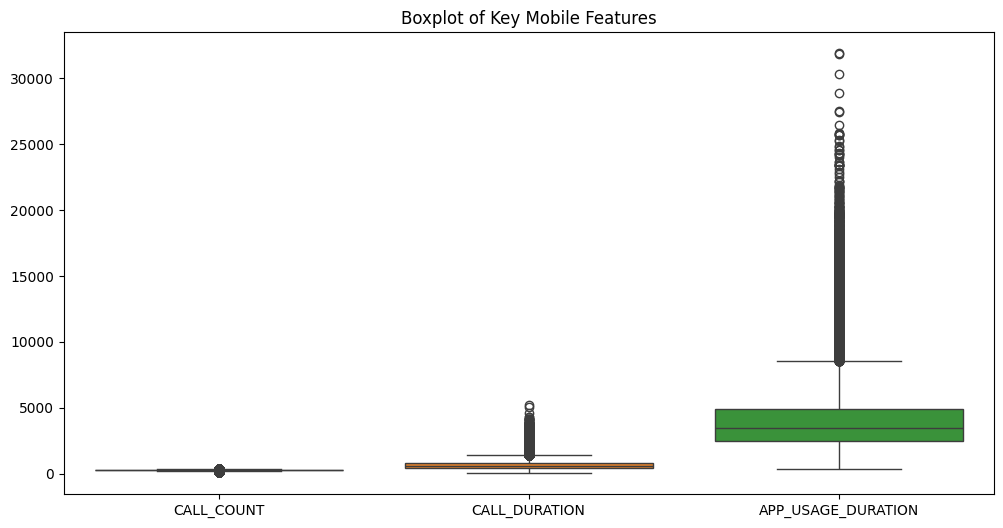


Categorical Feature Distribution (MOST_USED_APP_CATEGORY):
MOST_USED_APP_CATEGORY
Social Media     120608
Banking           87231
Entertainment     66237
Utility           33435
Name: count, dtype: int64
Imputed missing values in AMT_ANNUITY with median
Imputed missing values in AMT_GOODS_PRICE with median
Imputed missing values in AMT_CREDIT_SUM_sum with median
Imputed missing values in AMT_CREDIT_SUM_DEBT_sum with median
Imputed missing values in AMT_CREDIT_SUM_OVERDUE_sum with median
Imputed missing values in AMT_ANNUITY_prev_mean with median
Imputed missing values in AMT_APPLICATION_prev_mean with median
Imputed missing values in AMT_CREDIT_prev_mean with median
Imputed missing values in AMT_INSTALMENT_sum with median
Imputed missing values in AMT_PAYMENT_sum with median
Imputed missing values in AMT_BALANCE_cc_mean with median
Imputed missing values in AMT_CREDIT_LIMIT_ACTUAL_cc_mean with median
Imputed missing values in AMT_DRAWINGS_CURRENT_cc_sum with median
Imputed missing val

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load the dataset ---
# Why: Load the merged dataset with synthetic mobile features to begin exploration
base_df = reduce_memory_usage(pd.read_csv('merged_credit_data_with_mobile.csv'))

# --- 1. Check Data Integrity ---
# Why: Ensure no duplicates, correct shape, and appropriate data types
print("Dataset Shape:", base_df.shape)  # Should be (307511, 85)
print("Duplicate SK_ID_CURR:", base_df['SK_ID_CURR'].duplicated().sum())  # Should be 0

# Check data types
# Why: Confirm numeric and categorical columns are correctly typed
print("\nData Types:")
print(base_df.dtypes)

# --- 2. Assess Missing Values ---
# Why: Identify columns with missing data to decide on imputation or removal
missing_data = base_df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
print("\nColumns with Missing Values:")
print(missing_data)
missing_percentage = (missing_data / len(base_df)) * 100
print("\nMissing Values Percentage:")
print(missing_percentage)

# --- 3. Validate Synthetic Mobile Features ---
# Why: Ensure synthetic data is consistent and realistic
# Check if total calls equal incoming + outgoing
print("\nSynthetic Data Consistency Check:")
base_df['CALL_COUNT_CHECK'] = base_df['INCOMING_CALLS_COUNT'] + base_df['OUTGOING_CALLS_COUNT']
print("Rows where CALL_COUNT != INCOMING + OUTGOING:", 
      (base_df['CALL_COUNT'] != base_df['CALL_COUNT_CHECK']).sum())
base_df = base_df.drop('CALL_COUNT_CHECK', axis=1)  # Clean up temporary column

# Check for negative or unrealistic values
print("\nNegative Value Check:")
for col in ['CALL_COUNT', 'CALL_DURATION', 'APP_USAGE_DURATION', 'AIRTIME_TOPUP_AMOUNT']:
    print(f"{col} negative values:", (base_df[col] < 0).sum())

# --- 4. Identify Outliers ---
# Why: Detect extreme values that might affect analysis
numeric_cols = base_df.select_dtypes(include=['float64', 'float32', 'int32', 'int64']).columns
print("\nSummary Statistics for Numeric Columns:")
print(base_df[numeric_cols].describe())

# Visualize outliers for key features
plt.figure(figsize=(12, 6))
sns.boxplot(data=base_df[['CALL_COUNT', 'CALL_DURATION', 'APP_USAGE_DURATION']])
plt.title('Boxplot of Key Mobile Features')
plt.show()

# --- 5. Categorical Feature Distribution ---
# Why: Understand categorical feature distributions, especially for mobile data
print("\nCategorical Feature Distribution (MOST_USED_APP_CATEGORY):")
print(base_df['MOST_USED_APP_CATEGORY'].value_counts())

# --- 6. Basic Cleaning Steps ---
# Why: Handle missing values and data types to prepare for EDA
# Option 1: Impute missing numeric values with median
for col in numeric_cols:
    if base_df[col].isnull().sum() > 0:
        base_df[col] = base_df[col].fillna(base_df[col].median())
        print(f"Imputed missing values in {col} with median")

# Option 2: Impute missing categorical values with mode
categorical_cols = base_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if base_df[col].isnull().sum() > 0:
        base_df[col] = base_df[col].fillna(base_df[col].mode()[0])
        print(f"Imputed missing values in {col} with mode")

# --- 7. Save Cleaned Dataset ---
# Why: Preserve the cleaned dataset for EDA
base_df.to_csv('cleaned_credit_data_with_mobile.csv', index=False)
print("\nCleaned dataset saved as 'cleaned_credit_data_with_mobile.csv'")

# --- 8. Final Verification ---
# Why: Confirm cleaning was successful
print("\nRemaining Missing Values:")
print(base_df.isnull().sum().sum())
print("\nFinal Shape:", base_df.shape)

## Cleaning

Memory usage of dataframe is 199.42 MB
Memory usage after optimization is: 93.26 MB
Decreased by 53.2%
Columns in DataFrame: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'DAYS_CREDIT_mean', 'CREDIT_DAY_OVERDUE_mean', 'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_sum', 'MONTHS_BALANCE_mean', 'CREDIT_ACTIVE_mode', 'CREDIT_CURRENCY_mode', 'CREDIT_TYPE_mode', 'STATUS_mode', 'AMT_ANNUITY_prev_mean', 'AMT_APPLICATION_prev_mean', 'AMT_CREDIT_prev_mean', 'DAYS_DECISION_prev_mean', 'NAME_CONTRACT_STATUS_prev_mode', 'NAME_PAYMENT_TYPE_prev_mode', 'CODE_REJECT_REASON_prev_mode', 'NUM_INSTALMENT_NUMBER_count', 'DAYS_INSTALMENT_mean', 'DAYS_ENTRY_PAYMENT_mean', 'AMT_INSTALMENT_sum', '

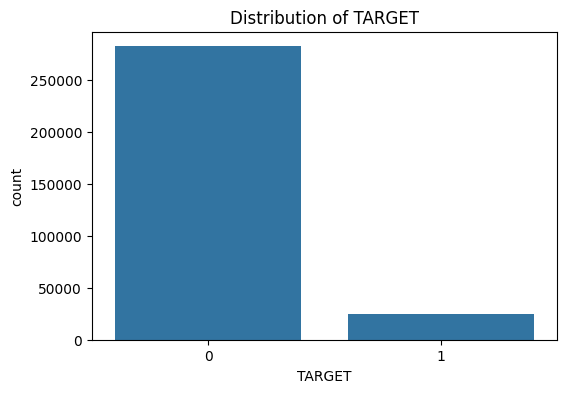


Top 10 Correlations with TARGET:
TARGET                             1.000000
DAYS_BIRTH                         0.078239
AMT_BALANCE_cc_mean                0.049729
CNT_CHILDREN                       0.019187
AMT_DRAWINGS_CURRENT_cc_sum        0.015948
AMT_CREDIT_SUM_OVERDUE_sum         0.005423
UNIQUE_APPS_USED                   0.001633
AMT_PAYMENT_CURRENT_cc_sum         0.001137
AMT_CREDIT_LIMIT_ACTUAL_cc_mean   -0.001263
SK_ID_CURR                        -0.002108
Name: TARGET, dtype: float64

Bottom 10 Correlations with TARGET:
INCOMING_SMS_COUNT     -0.559933
WEEKEND_CALL_COUNT     -0.614646
APP_USAGE_COUNT        -0.697433
INCOMING_CALLS_COUNT   -0.725602
SMS_COUNT              -0.748588
OUTGOING_SMS_COUNT     -0.846190
CALL_COUNT             -0.847358
DAY_CALLS_COUNT        -0.900222
WEEKDAY_CALL_COUNT     -0.906654
OUTGOING_CALLS_COUNT   -0.924138
Name: TARGET, dtype: float64


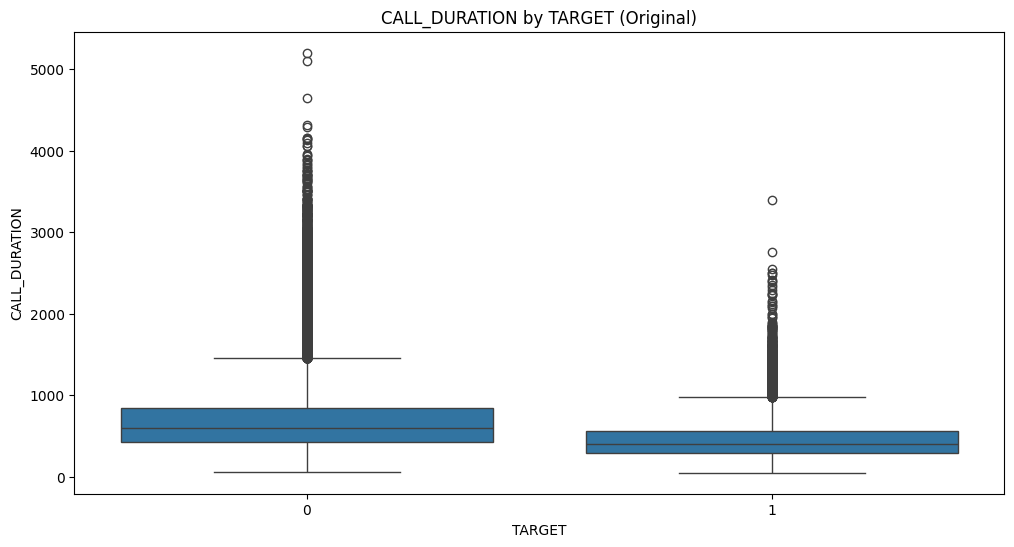

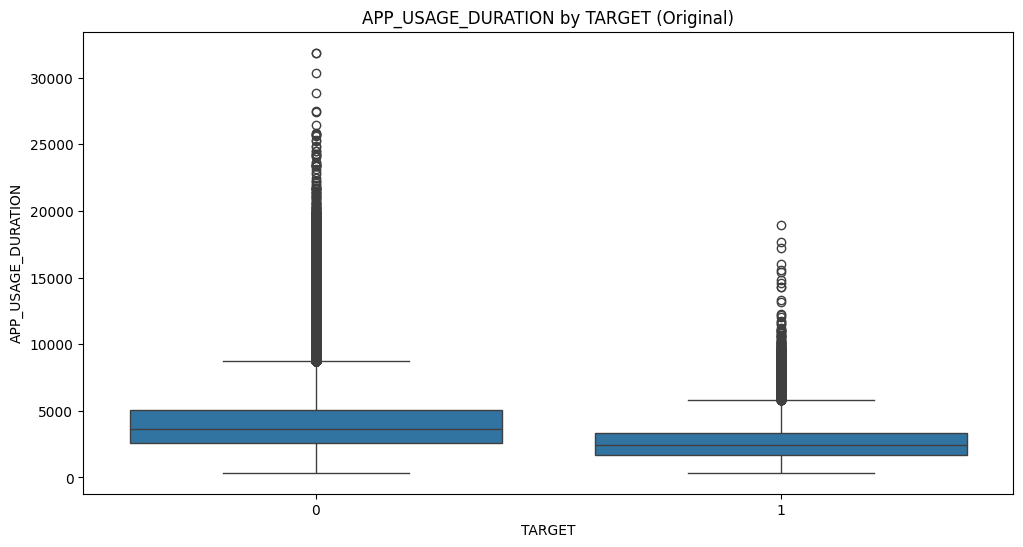

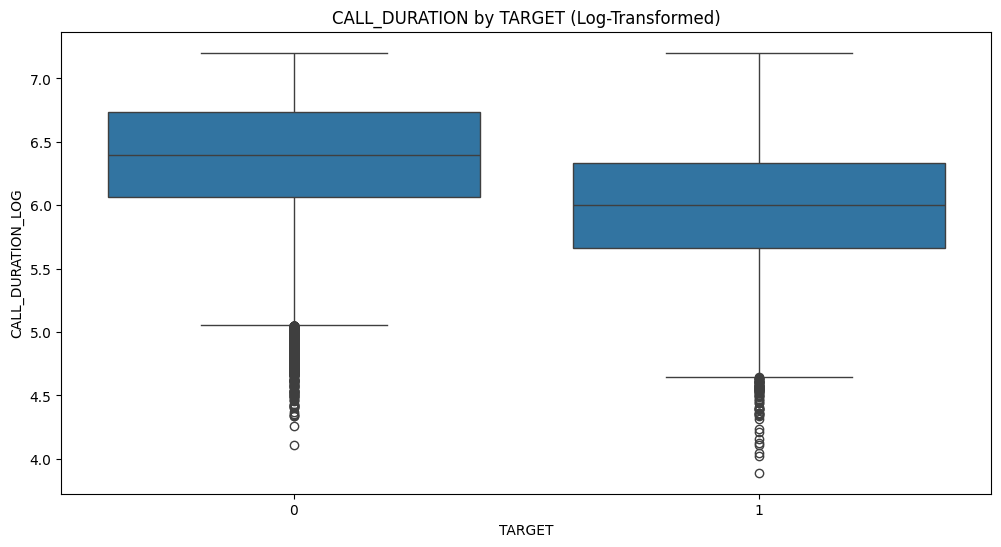

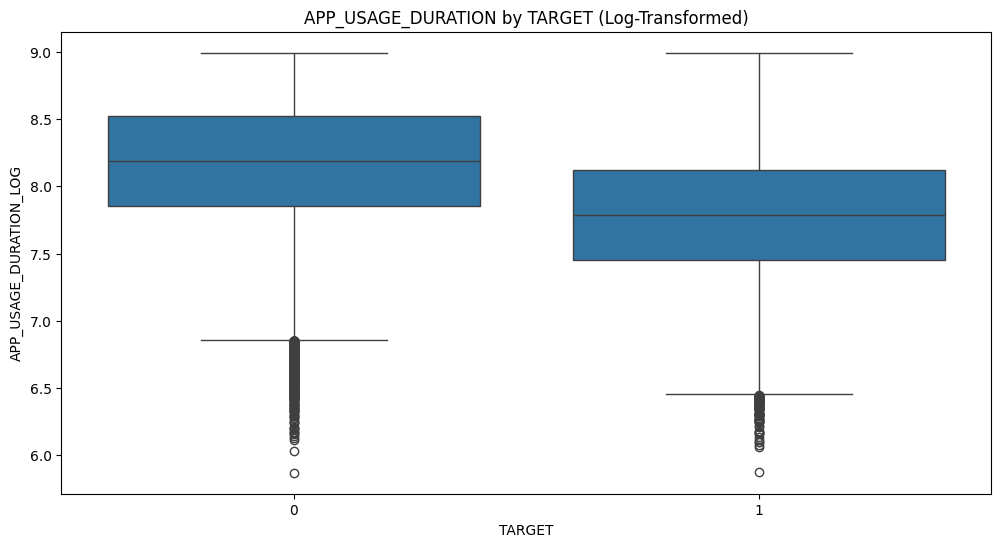


Updated cleaned dataset saved as 'cleaned_credit_data_with_mobile_v2.csv'

Summary of Transformed Features:
       CALL_DURATION_LOG  APP_USAGE_DURATION_LOG
count      307511.000000           307511.000000
mean            6.356445                8.145689
std             0.489400                0.489506
min             3.890625                5.871094
25%             6.023438                7.812500
50%             6.367188                8.156250
75%             6.710938                8.500000
max             7.203125                8.992188


In [32]:
# Load cleaned dataset with memory optimization
base_df = reduce_memory_usage(pd.read_csv('cleaned_credit_data_with_mobile.csv'))

# --- Diagnostic Check ---
# Why: Verify TARGET is present
print("Columns in DataFrame:", base_df.columns.tolist())
print("TARGET present:", 'TARGET' in base_df.columns)
if 'TARGET' not in base_df.columns:
    # Restore TARGET from original dataset
    original_df = pd.read_csv('merged_credit_data_with_mobile.csv')
    base_df = base_df.merge(original_df[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
    print("TARGET restored from original dataset")
    print("Updated columns:", base_df.columns.tolist())

# --- 1. Target Distribution ---
# Why: Check class balance for modeling
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=base_df)
plt.title('Distribution of TARGET')
plt.show()

# --- 2. Correlation with TARGET ---
# Why: Identify key predictors
# Include all integer and float types to capture TARGET (e.g., int8)
numeric_cols = base_df.select_dtypes(include=['float64', 'float32', 'int32', 'int64', 'int8', 'int16']).columns
# Ensure TARGET is included even if not in numeric_cols due to type
if 'TARGET' in base_df.columns:
    all_numeric_cols = list(numeric_cols) + ['TARGET'] if 'TARGET' not in numeric_cols else list(numeric_cols)
    corr = base_df[all_numeric_cols].corr()['TARGET'].sort_values(ascending=False)
    print("\nTop 10 Correlations with TARGET:")
    print(corr.head(10))
    print("\nBottom 10 Correlations with TARGET:")
    print(corr.tail(10))
else:
    print("\nWarning: TARGET not found, correlation analysis skipped")

# --- 3. Visualize Key Features by TARGET ---
# Why: Explore differences in mobile and financial features
if 'TARGET' in base_df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='TARGET', y='CALL_DURATION', data=base_df)
    plt.title('CALL_DURATION by TARGET (Original)')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='TARGET', y='APP_USAGE_DURATION', data=base_df)
    plt.title('APP_USAGE_DURATION by TARGET (Original)')
    plt.show()
else:
    print("\nWarning: TARGET not found, visualizations skipped")

# --- 4. Handle Outliers and Skewness ---
# Why: Log-transform skewed features and cap extreme values
def log_transform_and_cap(df, column, cap_percentile=95):
    # Perform transformation with higher precision
    df[f'{column}_LOG'] = np.log1p(df[column]).astype(np.float32)  # Use float32 to avoid overflow
    upper_limit = df[f'{column}_LOG'].quantile(cap_percentile / 100)
    df[f'{column}_LOG'] = np.where(df[f'{column}_LOG'] > upper_limit, upper_limit, df[f'{column}_LOG'])
    return df

if 'CALL_DURATION' in base_df.columns and 'APP_USAGE_DURATION' in base_df.columns:
    base_df = log_transform_and_cap(base_df, 'CALL_DURATION')
    base_df = log_transform_and_cap(base_df, 'APP_USAGE_DURATION')

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='TARGET', y='CALL_DURATION_LOG', data=base_df)
    plt.title('CALL_DURATION by TARGET (Log-Transformed)')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='TARGET', y='APP_USAGE_DURATION_LOG', data=base_df)
    plt.title('APP_USAGE_DURATION by TARGET (Log-Transformed)')
    plt.show()
else:
    print("\nWarning: Required columns not found, transformation skipped")

# --- 5. Re-Save Cleaned Dataset ---
# Why: Preserve changes with transformed features
base_df.to_csv('cleaned_credit_data_with_mobile_v2.csv', index=False)
print("\nUpdated cleaned dataset saved as 'cleaned_credit_data_with_mobile_v2.csv'")

# --- 6. Verify Transformation ---
# Why: Ensure transformation reduced skewness
if 'CALL_DURATION_LOG' in base_df.columns and 'APP_USAGE_DURATION_LOG' in base_df.columns:
    print("\nSummary of Transformed Features:")
    print(base_df[['CALL_DURATION_LOG', 'APP_USAGE_DURATION_LOG']].describe())
else:
    print("\nWarning: Transformed features not generated")

Memory usage of dataframe is 204.11 MB
Memory usage after optimization is: 94.43 MB
Decreased by 53.7%
TARGET Distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


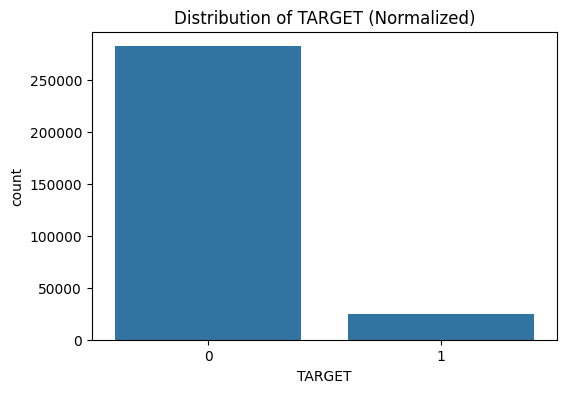


Selected Features (Correlation > 0.05):
['TARGET', 'OUTGOING_CALLS_COUNT', 'WEEKDAY_CALL_COUNT', 'DAY_CALLS_COUNT', 'CALL_COUNT', 'OUTGOING_SMS_COUNT', 'SMS_COUNT', 'INCOMING_CALLS_COUNT', 'APP_USAGE_COUNT', 'WEEKEND_CALL_COUNT', 'INCOMING_SMS_COUNT', 'NIGHT_CALLS_COUNT', 'UNIQUE_CONTACTS_CALLED', 'AIRTIME_TOPUP_COUNT', 'UNIQUE_SMS_CONTACTS', 'DAYS_BIRTH']

Dataset Split:
Training set size: 246008, Test set size: 61503

Preprocessed dataset saved as 'preprocessed_credit_data_v1.csv'


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load optimized dataset
base_df = reduce_memory_usage(pd.read_csv('cleaned_credit_data_with_mobile_v2.csv'))

# --- 1. Confirm Class Imbalance ---
print("TARGET Distribution:")
print(base_df['TARGET'].value_counts(normalize=True))
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=base_df)
plt.title('Distribution of TARGET (Normalized)')
plt.show()

# --- 2. Feature Selection Based on Correlation ---
numeric_cols = base_df.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32', 'int64']).columns
corr_threshold = 0.05  # Arbitrary threshold for significance
corr = base_df[numeric_cols].corr()['TARGET'].abs().sort_values(ascending=False)
selected_features = corr[corr > corr_threshold].index.tolist()
print("\nSelected Features (Correlation > 0.05):")
print(selected_features)

# --- 3. Encode Categorical Features ---
categorical_cols = base_df.select_dtypes(include=['object']).columns
base_df = pd.get_dummies(base_df, columns=categorical_cols, drop_first=True)

# --- 4. Scale Numeric Features ---
scaler = StandardScaler()
features_to_scale = [col for col in selected_features if col != 'TARGET']
base_df[features_to_scale] = scaler.fit_transform(base_df[features_to_scale])

# --- 5. Split Dataset ---
X = base_df.drop('TARGET', axis=1)
y = base_df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nDataset Split:")
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# --- 6. Save Preprocessed Data ---
base_df.to_csv('preprocessed_credit_data_v1.csv', index=False)
print("\nPreprocessed dataset saved as 'preprocessed_credit_data_v1.csv'")


Value Counts for CODE_GENDER:
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64
Number of Invalid Entries ('XNA', 'NA', 'Unknown') in CODE_GENDER: 4

Value Counts for NAME_CONTRACT_TYPE:
NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64
Number of Invalid Entries ('XNA', 'NA', 'Unknown') in NAME_CONTRACT_TYPE: 0

Value Counts for OCCUPATION_TYPE:
OCCUPATION_TYPE
Laborers                 151577
Sales staff               32102
Core staff                27570
Managers                  21371
Drivers                   18603
High skill tech staff     11380
Accountants                9813
Medicine staff             8537
Security staff             6721
Cooking staff              5946
Cleaning staff             4653
Private service staff      2652
Low-skill Laborers         2093
Waiters/barmen staff       1348
Secretaries                1305
Realty agents               751
HR staff                    563
IT staff      

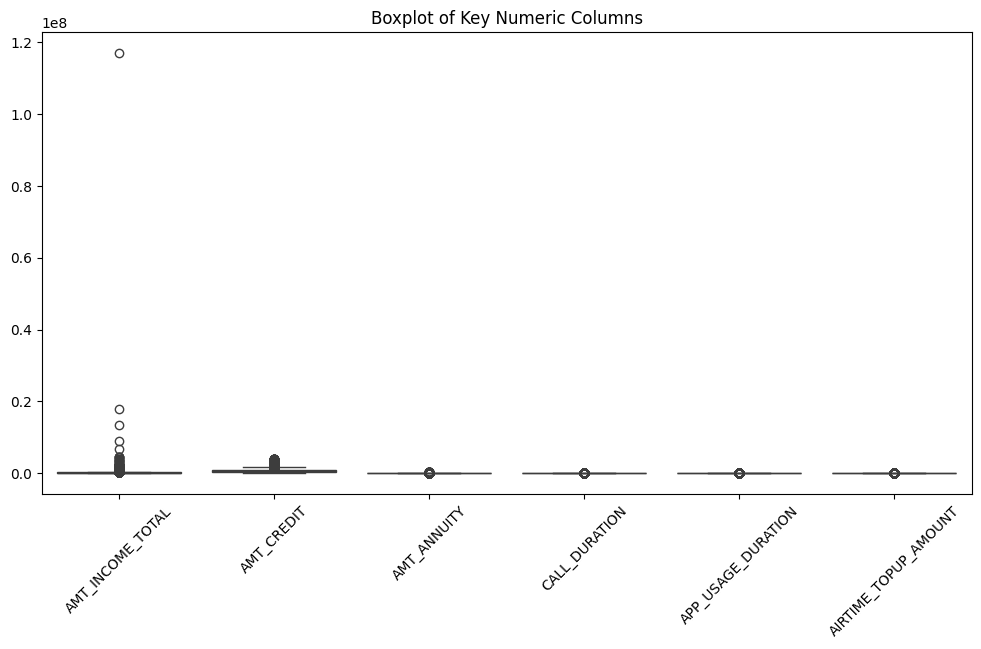


Removed 4 rows with 'XNA' in CODE_GENDER
Remaining rows: 307507

Columns with >30% Missing Values After Cleanup:
['MONTHS_BALANCE_mean', 'MONTHS_BALANCE_cc_mean', 'SK_DPD_cc_mean']

Dropped columns: ['MONTHS_BALANCE_mean', 'MONTHS_BALANCE_cc_mean', 'SK_DPD_cc_mean']

Updated cleaned dataset saved as 'cleaned_credit_data_with_mobile_v3.csv'

Remaining Columns:
['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'DAYS_CREDIT_mean', 'CREDIT_DAY_OVERDUE_mean', 'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_sum', 'CREDIT_ACTIVE_mode', 'CREDIT_CURRENCY_mode', 'CREDIT_TYPE_mode', 'STATUS_mode', 'AMT_ANNUITY_prev_mean', 'AMT_APPLICATION_prev_mean', 'AMT_CREDIT_prev_mean', 'DAYS_DECISION

In [47]:
base_df = pd.read_csv('cleaned_credit_data_with_mobile_v2.csv')

# --- 1. Check for Abnormal Values ---
# Categorical columns to inspect
categorical_cols = ['CODE_GENDER', 'NAME_CONTRACT_TYPE', 'OCCUPATION_TYPE', 'MOST_USED_APP_CATEGORY']
for col in categorical_cols:
    print(f"\nValue Counts for {col}:")
    print(base_df[col].value_counts())
    invalid_values = base_df[col].isin(['XNA', 'NA', 'Unknown']).sum()
    print(f"Number of Invalid Entries ('XNA', 'NA', 'Unknown') in {col}: {invalid_values}")

# Numeric columns for outliers and negatives
numeric_cols = base_df.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32', 'int64']).columns
abnormal_numeric_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'CALL_DURATION', 'APP_USAGE_DURATION', 'AIRTIME_TOPUP_AMOUNT']
print("\nSummary Statistics for Numeric Columns:")
print(base_df[abnormal_numeric_cols].describe())

# Check for negative values in numeric columns
negative_values = base_df[abnormal_numeric_cols].lt(0).sum()
print("\nNumeric Columns with Negative Values:")
print(negative_values[negative_values > 0])

# Visualize outliers in numeric columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=base_df[abnormal_numeric_cols])
plt.title('Boxplot of Key Numeric Columns')
plt.xticks(rotation=45)
plt.show()

# --- 2. Handle Abnormal Values ---
# Remove rows with 'XNA' in CODE_GENDER
initial_rows = base_df.shape[0]
if 'CODE_GENDER' in base_df.columns and base_df['CODE_GENDER'].isin(['XNA']).sum() > 0:
    base_df = base_df[base_df['CODE_GENDER'] != 'XNA']
    print(f"\nRemoved {initial_rows - base_df.shape[0]} rows with 'XNA' in CODE_GENDER")
    print(f"Remaining rows: {base_df.shape[0]}")

# Replace other invalid categorical values with NaN
for col in categorical_cols:
    if base_df[col].isin(['NA', 'Unknown']).sum() > 0:
        base_df[col] = base_df[col].replace(['NA', 'Unknown'], np.nan)
        print(f"Replaced 'NA' and 'Unknown' with NaN in {col}")

# --- 3. Check for Columns with Little to No Values Filled ---
# Recalculate missingness after handling abnormalities
missing_percent = base_df.isnull().mean() * 100
sparse_columns = missing_percent[missing_percent > 30].index.tolist()
print("\nColumns with >30% Missing Values After Cleanup:")
print(sparse_columns)

# --- 4. Remove Identified Sparse Columns ---
columns_to_drop = sparse_columns
if columns_to_drop:
    base_df = base_df.drop(columns=columns_to_drop)
    print(f"\nDropped columns: {columns_to_drop}")

# --- 5. Save Updated Dataset ---
base_df.to_csv('cleaned_credit_data_with_mobile_v3.csv', index=False)
print("\nUpdated cleaned dataset saved as 'cleaned_credit_data_with_mobile_v3.csv'")

# --- 6. Verify Remaining Columns and Rows ---
print("\nRemaining Columns:")
print(base_df.columns.tolist())
print(f"\nTotal Remaining Rows: {base_df.shape[0]}")

In [52]:
base_df = pd.read_csv('cleaned_credit_data_with_mobile_v3.csv')

# --- 1. Recheck Missingness ---
missing_percent = base_df.isnull().mean() * 100
print("\nMissing Percentage for All Columns:")
print(missing_percent.sort_values(ascending=False).head(10))  # Top 10 missing columns

# Identify remaining sparse columns (e.g., >30% or adjust to 50%)
sparse_columns = missing_percent[missing_percent > 30].index.tolist()
if sparse_columns:
    print("\nColumns with >30% Missing Values:")
    print(sparse_columns)
else:
    print("\nNo columns with >30% missing values.")

# --- 2. Check Correlations for Credit Card Related Columns ---
cc_related_cols = [col for col in base_df.columns if col.endswith('_cc_') or 'cc' in col]
numeric_cols = base_df.select_dtypes(include=['float32', 'float64', 'int8', 'int16', 'int32', 'int64']).columns
corr_cols = [col for col in cc_related_cols if col in numeric_cols and col != 'TARGET']
if corr_cols:
    corr = base_df[corr_cols + ['TARGET']].corr()['TARGET'].sort_values(ascending=False)
    print("\nCorrelations with TARGET for Credit Card Columns:")
    print(corr)
else:
    print("\nNo remaining credit card columns to correlate.")

# --- 3. Decide on Associated Columns ---
columns_to_drop = []
if sparse_columns:
    columns_to_drop.extend(sparse_columns)
    print(f"\nColumns to drop due to >30% missingness: {columns_to_drop}")

# Optionally drop low-correlation cc columns (e.g., <0.01 absolute correlation)
if corr_cols:
    low_corr_cols = [col for col in corr_cols if abs(corr[col]) < 0.01 and col not in columns_to_drop]
    if low_corr_cols:
        columns_to_drop.extend(low_corr_cols)
        print(f"\nColumns to drop due to low correlation (<0.01) with TARGET: {low_corr_cols}")

if columns_to_drop:
    base_df = base_df.drop(columns=columns_to_drop)
    print(f"\nDropped columns: {columns_to_drop}")

# --- 4. Save Updated Dataset ---
base_df.to_csv('cleaned_credit_data_with_mobile_v4.csv', index=False)
print("\nUpdated cleaned dataset saved as 'cleaned_credit_data_with_mobile_v4.csv'")

# --- 5. Verify Remaining Columns and Rows ---
print("\nRemaining Columns:")
print(base_df.columns.tolist())
print(f"\nTotal Remaining Rows: {base_df.shape[0]}")


Missing Percentage for All Columns:
CREDIT_DAY_OVERDUE_mean           14.315121
DAYS_CREDIT_mean                  14.315121
CNT_INSTALMENT_FUTURE_pos_mean     5.883118
CNT_INSTALMENT_pos_mean            5.883118
SK_DPD_pos_mean                    5.875313
MONTHS_BALANCE_pos_mean            5.875313
DAYS_DECISION_prev_mean            5.350773
DAYS_ENTRY_PAYMENT_mean            5.162809
DAYS_INSTALMENT_mean               5.160208
NUM_INSTALMENT_NUMBER_count        5.160208
dtype: float64

No columns with >30% missing values.

Correlations with TARGET for Credit Card Columns:
TARGET                             1.000000
AMT_BALANCE_cc_mean                0.049728
AMT_DRAWINGS_CURRENT_cc_sum        0.015947
AMT_PAYMENT_CURRENT_cc_sum         0.001136
AMT_CREDIT_LIMIT_ACTUAL_cc_mean   -0.001263
Name: TARGET, dtype: float64

Columns to drop due to low correlation (<0.01) with TARGET: ['AMT_CREDIT_LIMIT_ACTUAL_cc_mean', 'AMT_PAYMENT_CURRENT_cc_sum']

Dropped columns: ['AMT_CREDIT_LIMIT_ACTUAL

## Feature Eng

In [55]:
base_df = pd.read_csv('cleaned_credit_data_with_mobile_v4.csv')

# Avoid division by zero and handle missing values
def safe_divide(numerator, denominator):
    return np.where(denominator != 0, numerator / denominator, np.nan)

# Create new features
base_df['AVG_CALL_LENGTH'] = safe_divide(base_df['CALL_DURATION'], base_df['CALL_COUNT'])
base_df['AVG_APP_USAGE_SESSION'] = safe_divide(base_df['APP_USAGE_DURATION'], base_df['APP_USAGE_COUNT'])
base_df['TOTAL_MOBILE_ACTIVITY'] = base_df['CALL_DURATION'] + base_df['APP_USAGE_DURATION']
base_df['CALL_TO_SMS_RATIO'] = safe_divide(base_df['CALL_COUNT'], base_df['SMS_COUNT'])

# --- 2. Verify New Features ---
print("\nSummary Statistics for New Features:")
print(base_df[['AVG_CALL_LENGTH', 'AVG_APP_USAGE_SESSION', 'TOTAL_MOBILE_ACTIVITY', 'CALL_TO_SMS_RATIO']].describe())

# Check for infinite or negative values
inf_values = base_df[['AVG_CALL_LENGTH', 'AVG_APP_USAGE_SESSION', 'CALL_TO_SMS_RATIO']].isin([np.inf, -np.inf]).sum()
print("\nInfinite Values in New Features:")
print(inf_values[inf_values > 0])

# --- 3. Handle Missing or Infinite Values ---
base_df['AVG_CALL_LENGTH'] = base_df['AVG_CALL_LENGTH'].replace([np.inf, -np.inf], np.nan)
base_df['AVG_APP_USAGE_SESSION'] = base_df['AVG_APP_USAGE_SESSION'].replace([np.inf, -np.inf], np.nan)
base_df['CALL_TO_SMS_RATIO'] = base_df['CALL_TO_SMS_RATIO'].replace([np.inf, -np.inf], np.nan)

# --- 4. Save Updated Dataset ---
base_df.to_csv('cleaned_credit_data_with_mobile_v5.csv', index=False)
print("\nUpdated cleaned dataset saved as 'cleaned_credit_data_with_mobile_v5.csv'")

# --- 5. Verify Remaining Columns ---
print("\nRemaining Columns:")
print(base_df.columns.tolist())


Summary Statistics for New Features:
       AVG_CALL_LENGTH  AVG_APP_USAGE_SESSION  TOTAL_MOBILE_ACTIVITY  \
count    307507.000000          307507.000000          307507.000000   
mean          2.276822              20.306893            4629.752031   
std           1.223170              10.954269            2191.277371   
min           0.198867               1.868783             603.400000   
25%           1.426582              12.727273            3112.000000   
50%           2.004673              17.862385            4171.500000   
75%           2.816993              25.143544            5626.000000   
max          19.540230             178.876404           32544.500000   

       CALL_TO_SMS_RATIO  
count      307507.000000  
mean            2.013882  
std             0.207390  
min             1.175182  
25%             1.869863  
50%             2.000000  
75%             2.143939  
max             3.382353  

Infinite Values in New Features:
Series([], dtype: int64)

Updated cl